# MINIMIZING CHURN OF SUBSCRIPTION PRODUCT THROUGH ANALYSIS OF FINANCIAL HABITS



__Market:__ the target audience is the entirety of a company'ssubscription base. They are the ones companies want to keep.

__Product:__ The subscription products that customers are already enrolled in can provide value that users may not have imagined, or that they may have forgotten

__Goal:__ The objective of this model is to predict which users are likely to churn, so that the company can focus on re-engaging these users with the product. These efforts can be email reminders about the benefits of the product, especially focusing on features that are new or that the user has shown to value.

### Business challenge

- The fintech company provides a subscription product to its users, which allows them to manage their bank accounts(saving accounts, credit cards, etc), provides them with personalized coupons, informs them of the latest low-APR loans available in the market, and educates them on the best available methods to save money (like videos on saving money on taxes, free courses on financial health, etc)


- We are in charge of identifying users who are likely to cncel their subscription so that we can start building new features that they may be interested in. These features can increase the engagement and interest of our useres towards the product.

### Data

- By subscribing too the membership, our customers have provided us with data on their finances, as well as how they handle those finances through the product. We also have some demographic information we acquired from them during the sign-up process.

- Financial dat can often be unreliable and delayed. As a result, companies can sometimes build their marketing models using only demographic data, and data relatted to finances handled through the product itself. Therefore, we will be restricting ourselves to only using that type of data. Furthermore, product-related data is more indicative of what new features we should be creating as company.

In [1]:
# importing libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

In [2]:
# loading dataset

df = pd.read_csv('churn_data.csv')

# EXPLORATORY DATA ANALYSIS_EDA

In [3]:
df.head()

,user,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,...,waiting_4_loan,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred
0,55409,0,37.0,na,NaN,0,0,0,0,0,...,0,0,0,0,Leo,1,0,NaN,0.00,0
1,23547,0,28.0,R,486.0,0,0,1,0,0,...,0,0,0,0,Leo,0,0,44.0,1.47,1
2,58313,0,35.0,R,561.0,47,2,86,47,0,...,0,0,0,0,Capricorn,1,0,65.0,2.17,0
3,8095,0,26.0,R,567.0,26,3,38,25,0,...,0,0,0,0,Capricorn,0,0,33.0,1.10,1
4,61353,1,27.0,na,NaN,0,0,2,0,0,...,0,0,0,0,Aries,1,0,1.0,0.03,0


In [4]:
# There are so many nulls in two columns, that it is better to remove the entire feature.
# Also we will remove the 4 rows with null vale in 'age' column

df = df[pd.notnull(df['age'])]

In [5]:
df = df.drop(['credit_score', 'rewards_earned'], axis = 1)

# EDA

In [6]:
# creating a copy of the original dataset

df2 = df.drop(['user', 'churn'], axis = 1)

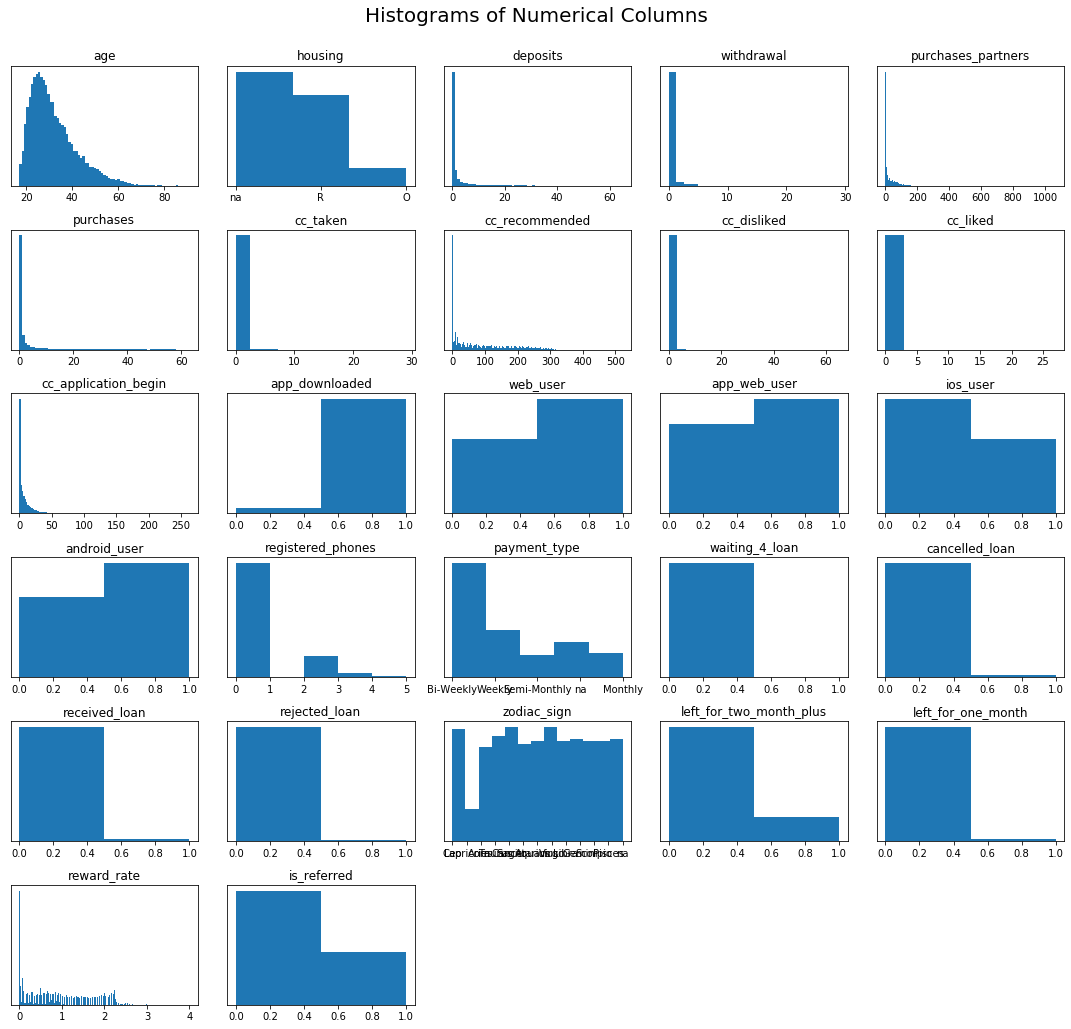

In [7]:
# Histogram of each feature

fig = plt.figure(figsize =(15, 15))
plt.suptitle('Histograms of Numerical Columns', fontsize = 20)

for i in range(1, df2.shape[1] + 1):
    plt.subplot(6, 5, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(df2.columns.values[i - 1])
    
    vals = np.size(df2.iloc[:, i -1].unique())
    
    plt.hist(df2.iloc[:, i - 1], bins = vals)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [8]:
# Now we will check the binary features. df2 has only binary columns

df2 = df[['housing', 'is_referred', 'app_downloaded', 'web_user', 
          'app_web_user', 'ios_user', 'android_user', 'registered_phones',
          'payment_type', 'waiting_4_loan', 'cancelled_loan', 'received_loan',
          'rejected_loan', 'zodiac_sign', 'left_for_two_month_plus', 
          'left_for_one_month', 'is_referred']]

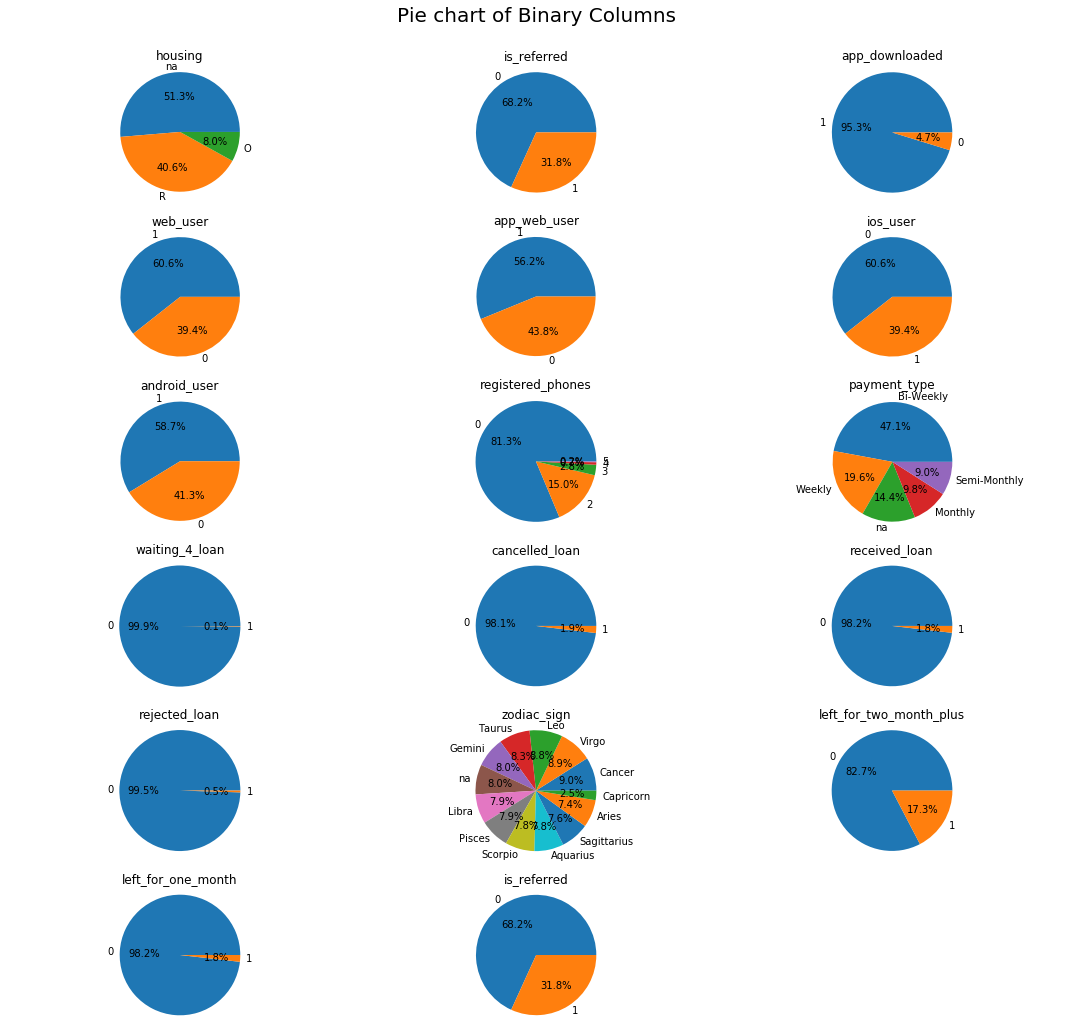

In [9]:
# Pie plot

fig = plt.figure(figsize =(15, 15))
plt.suptitle('Pie chart of Binary Columns', fontsize = 20)

for i in range(1, df2.shape[1] + 1):
    plt.subplot(6, 3, i)
    f = plt.gca()
    f.axes.get_yaxis().set_visible(False)
    f.set_title(df2.columns.values[i - 1])
    values = df2.iloc[:, i -1].value_counts(normalize = True).values
    index = df2.iloc[:, i - 1].value_counts(normalize = True).index
    plt.pie(values, labels = index, autopct = '%1.1f%%')
    plt.axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

- the ones we care about now are the ones with a subset very very small:
- we need to be sure that these fields are really usefull for using it in our model, because for now they show very small and potentially insignificant

- 'waiting_4_loan'
- 'cancelled_loan'
- 'received_loan'
- 'rejected_loan'
- 'left_for_one_month'

In [10]:
df[df2.waiting_4_loan == 1].churn.value_counts()

0    27
1     8
Name: churn, dtype: int64

In [11]:
df[df2.cancelled_loan == 1].churn.value_counts()

1    274
0    234
Name: churn, dtype: int64

In [12]:
df[df2.received_loan == 1].churn.value_counts()

1    292
0    199
Name: churn, dtype: int64

In [13]:
df[df2.rejected_loan == 1].churn.value_counts()

1    107
0     25
Name: churn, dtype: int64

In [14]:
df[df2.left_for_one_month == 1].churn.value_counts()

1    266
0    222
Name: churn, dtype: int64

### Correlations

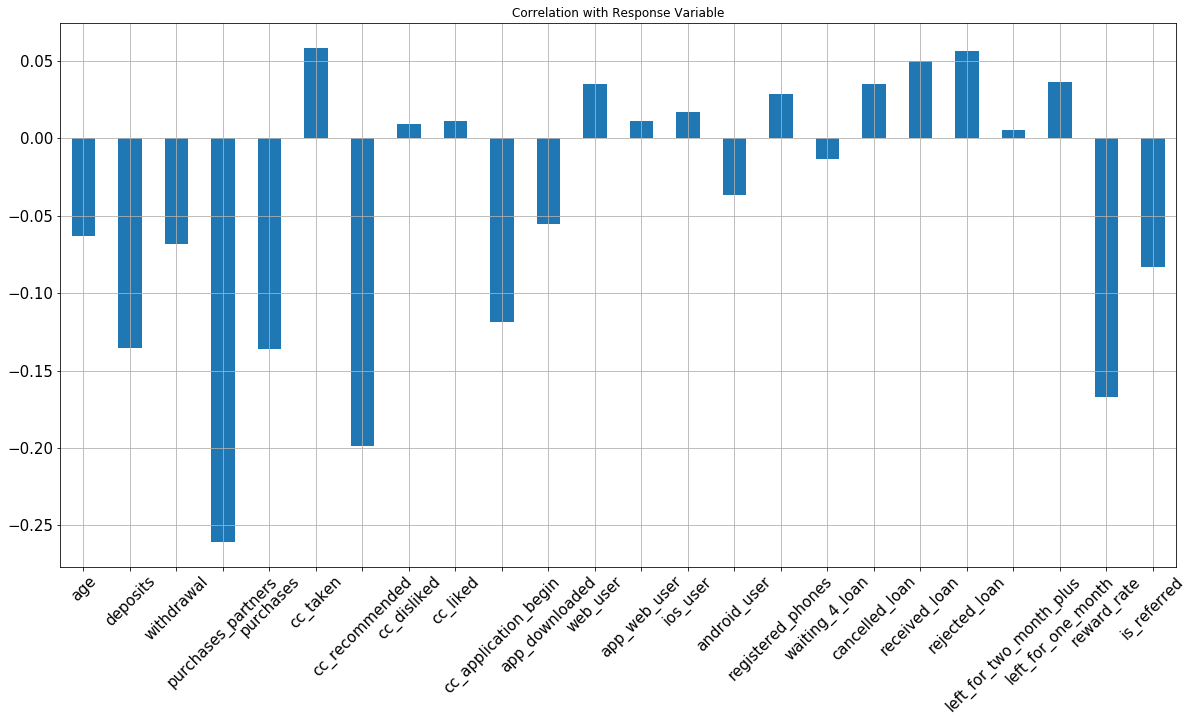

In [15]:
# Correlation between df.churn x df2

df.drop(['churn', 'user', 'housing', 'payment_type',
         'zodiac_sign'], axis = 1).corrwith(df.churn).plot.bar(
    figsize = (20, 10), title = 'Correlation with Response Variable',
              fontsize = 15, rot = 45, grid = True)

# Comments:

# {deposits, withdrawal, purchases_partners} makes sense to be negative related
# {cc_taken} it means that users with credit card with them will likely churn
# {ccc_like, cc_dislike} very small positive corralation
# {cc_application_begin} negative corr, the less app biguining the likely to churn
# {cc_downloaded} biggest the chance to stay with us if someone downloaded the app


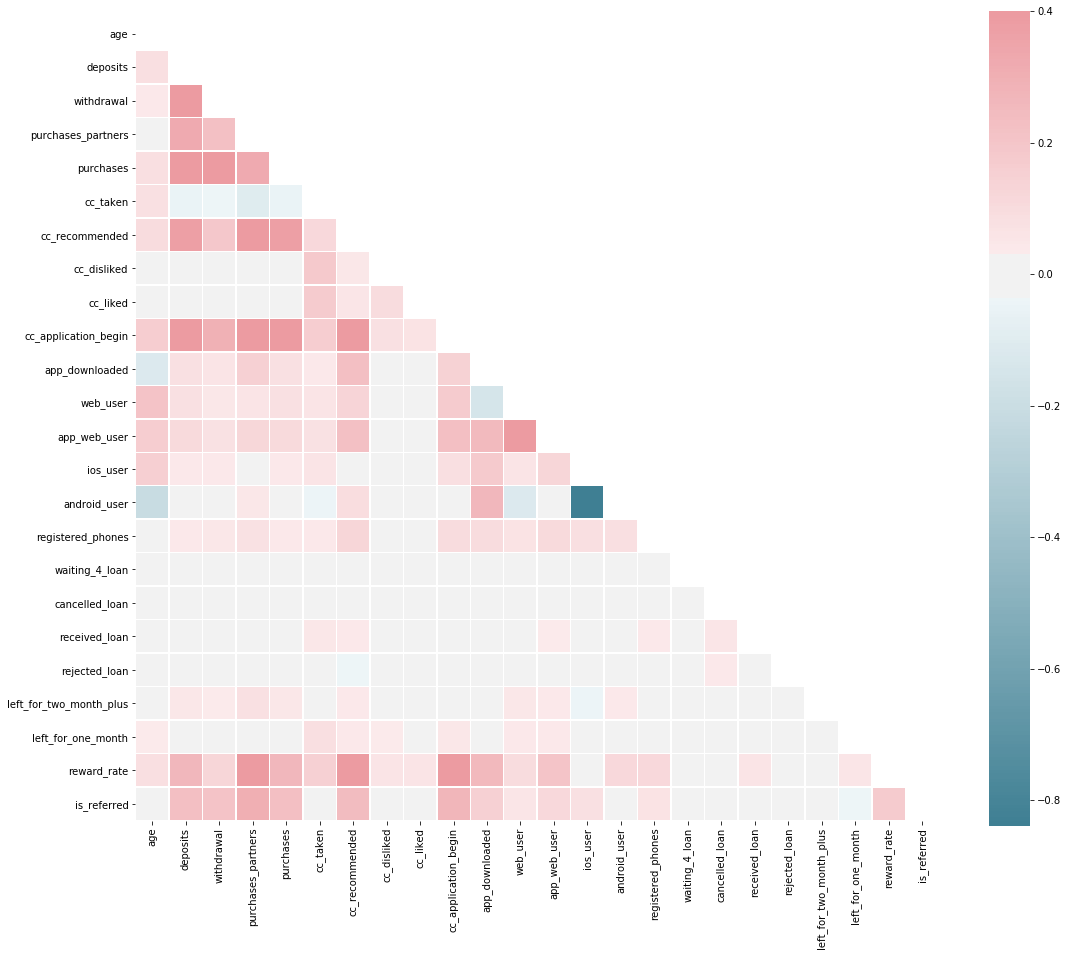

In [16]:
# Heatmap

corr = df.drop(['churn', 'user'], axis = 1).corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
fig, axes = plt.subplots(1, 1, figsize = (18, 15))
cmap = sb.diverging_palette(220, 10, as_cmap = True)
sb.heatmap(corr, mask = mask, square=True, annot = False, linewidth = 0.5,
           ax = axes, cmap = cmap, vmax = 0.4, center = 0)


In [17]:
# 'app_web_user' is a function of 'web_user' and 'app_downloaded', for that reason
# it is not a independent variable and we must remove it or some of them

df = df.drop(['app_web_user'], axis = 1)

In [18]:
df.to_csv('new_churn_data.csv', index = False)

# Preprocessing

- Label encoding (OneHotEncoding)
- Splitting training data
- Balancing data
- Feature Scaling

In [22]:
# Creating a identifier for the users, so that we check the results later on

user_identifier = df['user']

In [23]:
# Removing the users ID from the training set

df = df.drop(['user'], axis = 1)

### Label Encoding

In [24]:
df.housing.value_counts()

na    13856
R     10969
O      2171
Name: housing, dtype: int64

In [25]:
df = pd.get_dummies(df)
df.columns

Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtype='object')

__In oder to avoid DAMY VARIABLE trap, we should take off the columns which are causing correlated fields because we are considering all possible labels in this encoding__

In [26]:
df = df.drop(['housing_na', 'payment_type_na', 'zodiac_sign_na'], axis = 1)

### Pre-processing

In [27]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(df.drop(['churn'], axis = 1),
                                                    df['churn'], test_size = 0.2,
                                                    random_state = 0)

In [28]:
y_train.value_counts()

0    12656
1     8940
Name: churn, dtype: int64

### Balancing the data

Unbalanced dataset will bias the majority sample with same results
  

__DownSampling:__ Create a new dataset, and the majority sample will be downsampling in order to fit the size of the minority sample

- Disadvantage: we are loosing critical information by doing it


__UpSampling:__ it is better to use this option
- Artificial points method (it applies extrapolation)


In [29]:
# selecting which one has higher samples

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower  = neg_index
else:
    higher = neg_index
    lower  = pos_index

    
# Subsetting the higher sample
    
random.seed(0)
higher = np.random.choice(higher, size = len(lower))
lower = np.asarray(lower) # np.random returns a array. so we  set LOWER as a array too
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes, ] # because it has many columns
y_train = y_train.loc[new_indexes]   # because there is only 1 column

In [30]:
print(X_train.shape)
print(y_train.shape)

(17880, 41)
(17880,)


### Feature Scaling

In [31]:
# Standartization


from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train2 = pd.DataFrame(sc_x.fit_transform(X_train))
X_test2  = pd.DataFrame(sc_x.transform(X_test))

X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

# MODEL
- Fit model and training Set
- Predict Test Set
- Evaluating Results
- Cross Validation

In [32]:
# Fit model and training Set

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [33]:
# Predict Test Set

y_pred = classifier.predict(X_test)

-  Evaluating Results

In [34]:
cm = confusion_matrix(y_test, y_pred)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

Accuracy: 0.6137037037037038
Recall: 0.7452999104744852
f1_score: 0.6148449039881831
Precision: 0.5232558139534884


Test Data Accuracy: 0.6137


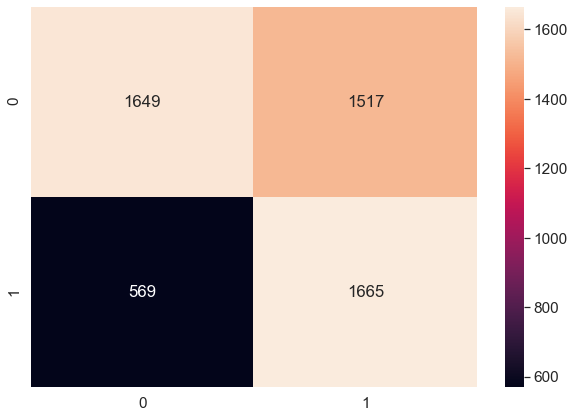

In [35]:
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize= (10,7))
sb.set(font_scale = 1.4)
sb.heatmap(df_cm, annot = True, fmt = 'g')
print('Test Data Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

- Cross Validation

In [36]:
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print('Logistic Accuracy: %0.3f (+/- %0.3f)' % (accuracies.mean(), accuracies.std() * 2))

Logistic Accuracy: 0.646 (+/- 0.018)


In [37]:
# Analysing coefficients

pd.concat([pd.DataFrame(X_train.columns, columns = ['features']),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ['coeff'])],
          axis = 1)

,features,coeff
0,age,-0.152907
1,deposits,0.623691
2,withdrawal,0.038357
3,purchases_partners,-0.763189
4,purchases,-0.747122
5,cc_taken,0.067228
6,cc_recommended,0.111516
7,cc_disliked,0.011968
8,cc_liked,-0.005431
9,cc_application_begin,0.018817


In [ ]:
# From this table above, we see the features that has  biggest correlation with the output
# DEPOSITS, PURCHASES_PARTNERS(neg), PURCHASES(neg), REWARD_RATE(neg)

- Feature Selection

In [38]:
classifier = LogisticRegression()

In [39]:
X_train.shape

(17880, 41)

In [40]:
# we speficy we want 20 columns in this

rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)

# it is informing which columns are included in our result
print(rfe.support_)

C:\Users\tulio\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[ True  True  True  True  True  True  True False False False False  True
  True False  True False  True  True  True  True  True  True  True  True
 False  True False False  True False False False False False False False
 False False False False False]


In [41]:
X_train.columns[rfe.support_]

Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_recommended', 'web_user', 'ios_user',
       'registered_phones', 'cancelled_loan', 'received_loan', 'rejected_loan',
       'left_for_two_month_plus', 'left_for_one_month', 'reward_rate',
       'is_referred', 'housing_O', 'payment_type_Bi-Weekly',
       'payment_type_Weekly'],
      dtype='object')

In [42]:
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1, 13, 18, 11,  6,  1,  1,  7,  1,  4,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  1, 21,  3,  1,  8, 22, 20, 10,  5,
       19,  9, 12, 15, 14, 16, 17])

as now we know which columns we use and the best ones, we are going to use them in our model

### Re-making the MODEL with the feature selected

In [43]:
# Fit model and training Set

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

LogisticRegression(random_state=0)

In [44]:
y_pred = classifier.predict(X_test[X_test.columns[rfe.support_]])

Accuracy: 0.6096296296296296
Recall: 0.7421665174574754
f1_score: 0.6113569321533923
Precision: 0.5197492163009404
Test Data Accuracy: 0.6096


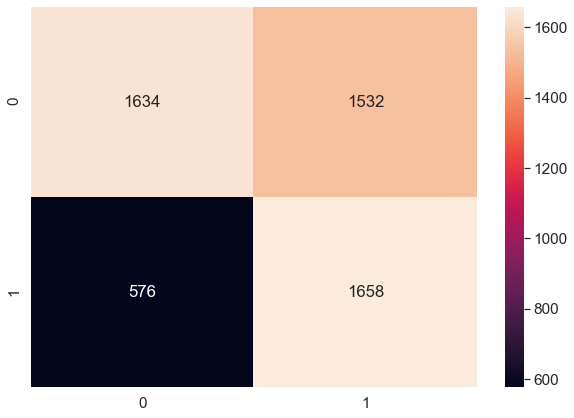

In [47]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize= (10,7))
sb.set(font_scale = 1.4)
sb.heatmap(df_cm, annot = True, fmt = 'g')
print('Test Data Accuracy: %0.4f' % accuracy_score(y_test, y_pred))

Results are very similar to the previous model

In [48]:
# Analysing coefficients

pd.concat([pd.DataFrame(X_train.columns[rfe.support_], columns = ['features']),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ['coeff'])],
          axis = 1)

,features,coeff
0,age,-0.149731
1,deposits,0.621500
2,withdrawal,0.040617
3,purchases_partners,-0.764068
4,purchases,-0.737987
5,cc_taken,0.073541
6,cc_recommended,0.129253
7,web_user,0.132541
8,ios_user,0.086428
9,registered_phones,0.095360


# FINAL RESULTS

In [49]:
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop = True)

In [50]:
final_results

,user,churn,predicted_churn
0,61353,1.0,1
1,67679,0.0,0
2,21269,0.0,0
3,69531,0.0,1
4,25997,0.0,0
...,...,...,...
5395,22377,0.0,1
5396,24291,1.0,1
5397,23740,0.0,1
5398,47663,1.0,0


- The model has provided us with an indication of which users are likely to churn. We have purposefully left the date of the expected churn open-ended because we are focused on only gauging the features that indicate disengagement with the product, and not the exact manner (like timeframe) in which users will disengage. In this case study we have chosen this open-ended emphasis to get a sense of those who are even just a BIT LIKELY to churn because we are not aiming to create new products for people who are going to leave us for sure, but for people who are starting to lose interest in the app.


- If, after creating new product features, we start seeing our model predict that less of our users are going to churn, then we can assume our customers are feeling more engaged with what we are offering them. We can move forward with these efforts by inquiring the opinions of our users about ournew features. If we want to transition into predicting churn more accurately, in order to put emphasis strictly on those leaving us, then we can add a time dimension to churn, which would add more accuracy to our model.